# Maquina de vectotres de soporte #

## Estado Planctónico Vs biofilm de Cepas de *S. aureus* [BAA-44, ATCC 29213 y ATCC 43300] Extración de Proteínas [AF:ACN] ##

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

# Etracción 1 #

In [2]:
import glob
fn = []
all_MS = pd.DataFrame()
#nombres=['MF']
for f in glob.glob("C:/Users/Usuario/OneDrive - UNIVERSIDAD INDUSTRIAL DE SANTANDER/Documents/Analisis_Datos_Quimica-main/Datos plan B/29213-43300/Extracción 1/*.txt"):
    df = pd.read_csv(f, header=None, delimiter=' ' )
    all_MS = pd.concat([all_MS, df], axis=1)
    fn.append(f) # Guardamos parte del nombre del archivo como una etiqueta de cada muestra
Datamz = all_MS[0] # realciones m/z
Data = all_MS[1] # Intensidades

In [3]:
DataIn=Data[0:20480]
DataIn.columns=range(DataIn.shape[1])
DataMz=Datamz[0:20480]
DataMz.columns=range(DataMz.shape[1])

In [4]:
EtPlanct = pd.read_excel('C:/Users/Usuario/OneDrive - UNIVERSIDAD INDUSTRIAL DE SANTANDER/Documents/Analisis_Datos_Quimica-main/Datos plan B/29213-43300/Extracción 1/Etiquetas.xlsx', sheet_name=0, header=None)

Y=EtPlanct[[2]]
Y1=pd.DataFrame(Y.set_axis(axis=1, labels=['Estado']))

### Análisis de Componentes Principales ###

In [5]:
from sklearn.preprocessing import StandardScaler, Normalizer
scaler=StandardScaler()
scaler.fit(DataIn) # calculo la media para poder hacer la transformacion
x_scaled=scaler.transform(DataIn)# Ahora si, escalo los datos y los normalizo

pca=PCA(n_components=10) # Otra opción es hacer pca hasta obtener un mínimo explicado ej.: pca=PCA(.85)
pca1=pca.fit(x_scaled.T) # obtener los componentes principales
datos_pca=pca.transform(x_scaled.T) # convertimos nuestros datos con las nuevas dimensiones de PCA, scores

#out = pca.fit_transform(valtn) # otra opción

# Esta celda es para observar la varianza explicada con 5 componentes, se podría variar a los que se quisiese
print("shape of datos_pca", datos_pca.shape)
expl = pca.explained_variance_ratio_
print(expl)
print('suma:',sum(expl[0:10]))
#Vemos que con 5 componentes tenemos algo mas del 85% de varianza explicada
datos_pca1=pd.DataFrame(datos_pca) # Convierte los datos pca en un DataFrame
datos_pca1=pd.concat([Y1, datos_pca1] ,axis=1) # Se agrega la columna del tipo de muestra

shape of datos_pca (40, 10)
[0.55587292 0.1309026  0.07498316 0.05933636 0.04250251 0.02570415
 0.01996444 0.01850123 0.01352907 0.01165986]
suma: 0.9529563070808652


In [6]:
scores_df = pd.DataFrame(datos_pca, columns = [f"PC{i+1}" for i in range(datos_pca.shape[1])])
scores_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-43.760700,-13.261182,22.522263,-17.386749,8.015201,0.371893,1.578002,-3.499896,-6.546451,-2.033960
1,-44.541320,-15.086721,19.075000,-14.340618,5.743592,0.099351,-0.683324,-1.253551,-8.903055,-1.990691
2,-42.121688,-9.274356,33.307586,-20.937860,7.142367,0.858801,0.353938,1.560633,-1.994904,-0.225012
3,-44.284669,-18.206642,-7.523964,-0.133762,2.204155,-0.521507,3.927065,-8.338903,-4.969339,-2.598790
4,-41.274648,-3.229088,-18.496507,12.551598,-5.498788,1.586843,-5.072501,6.974346,12.269574,4.361841


C:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


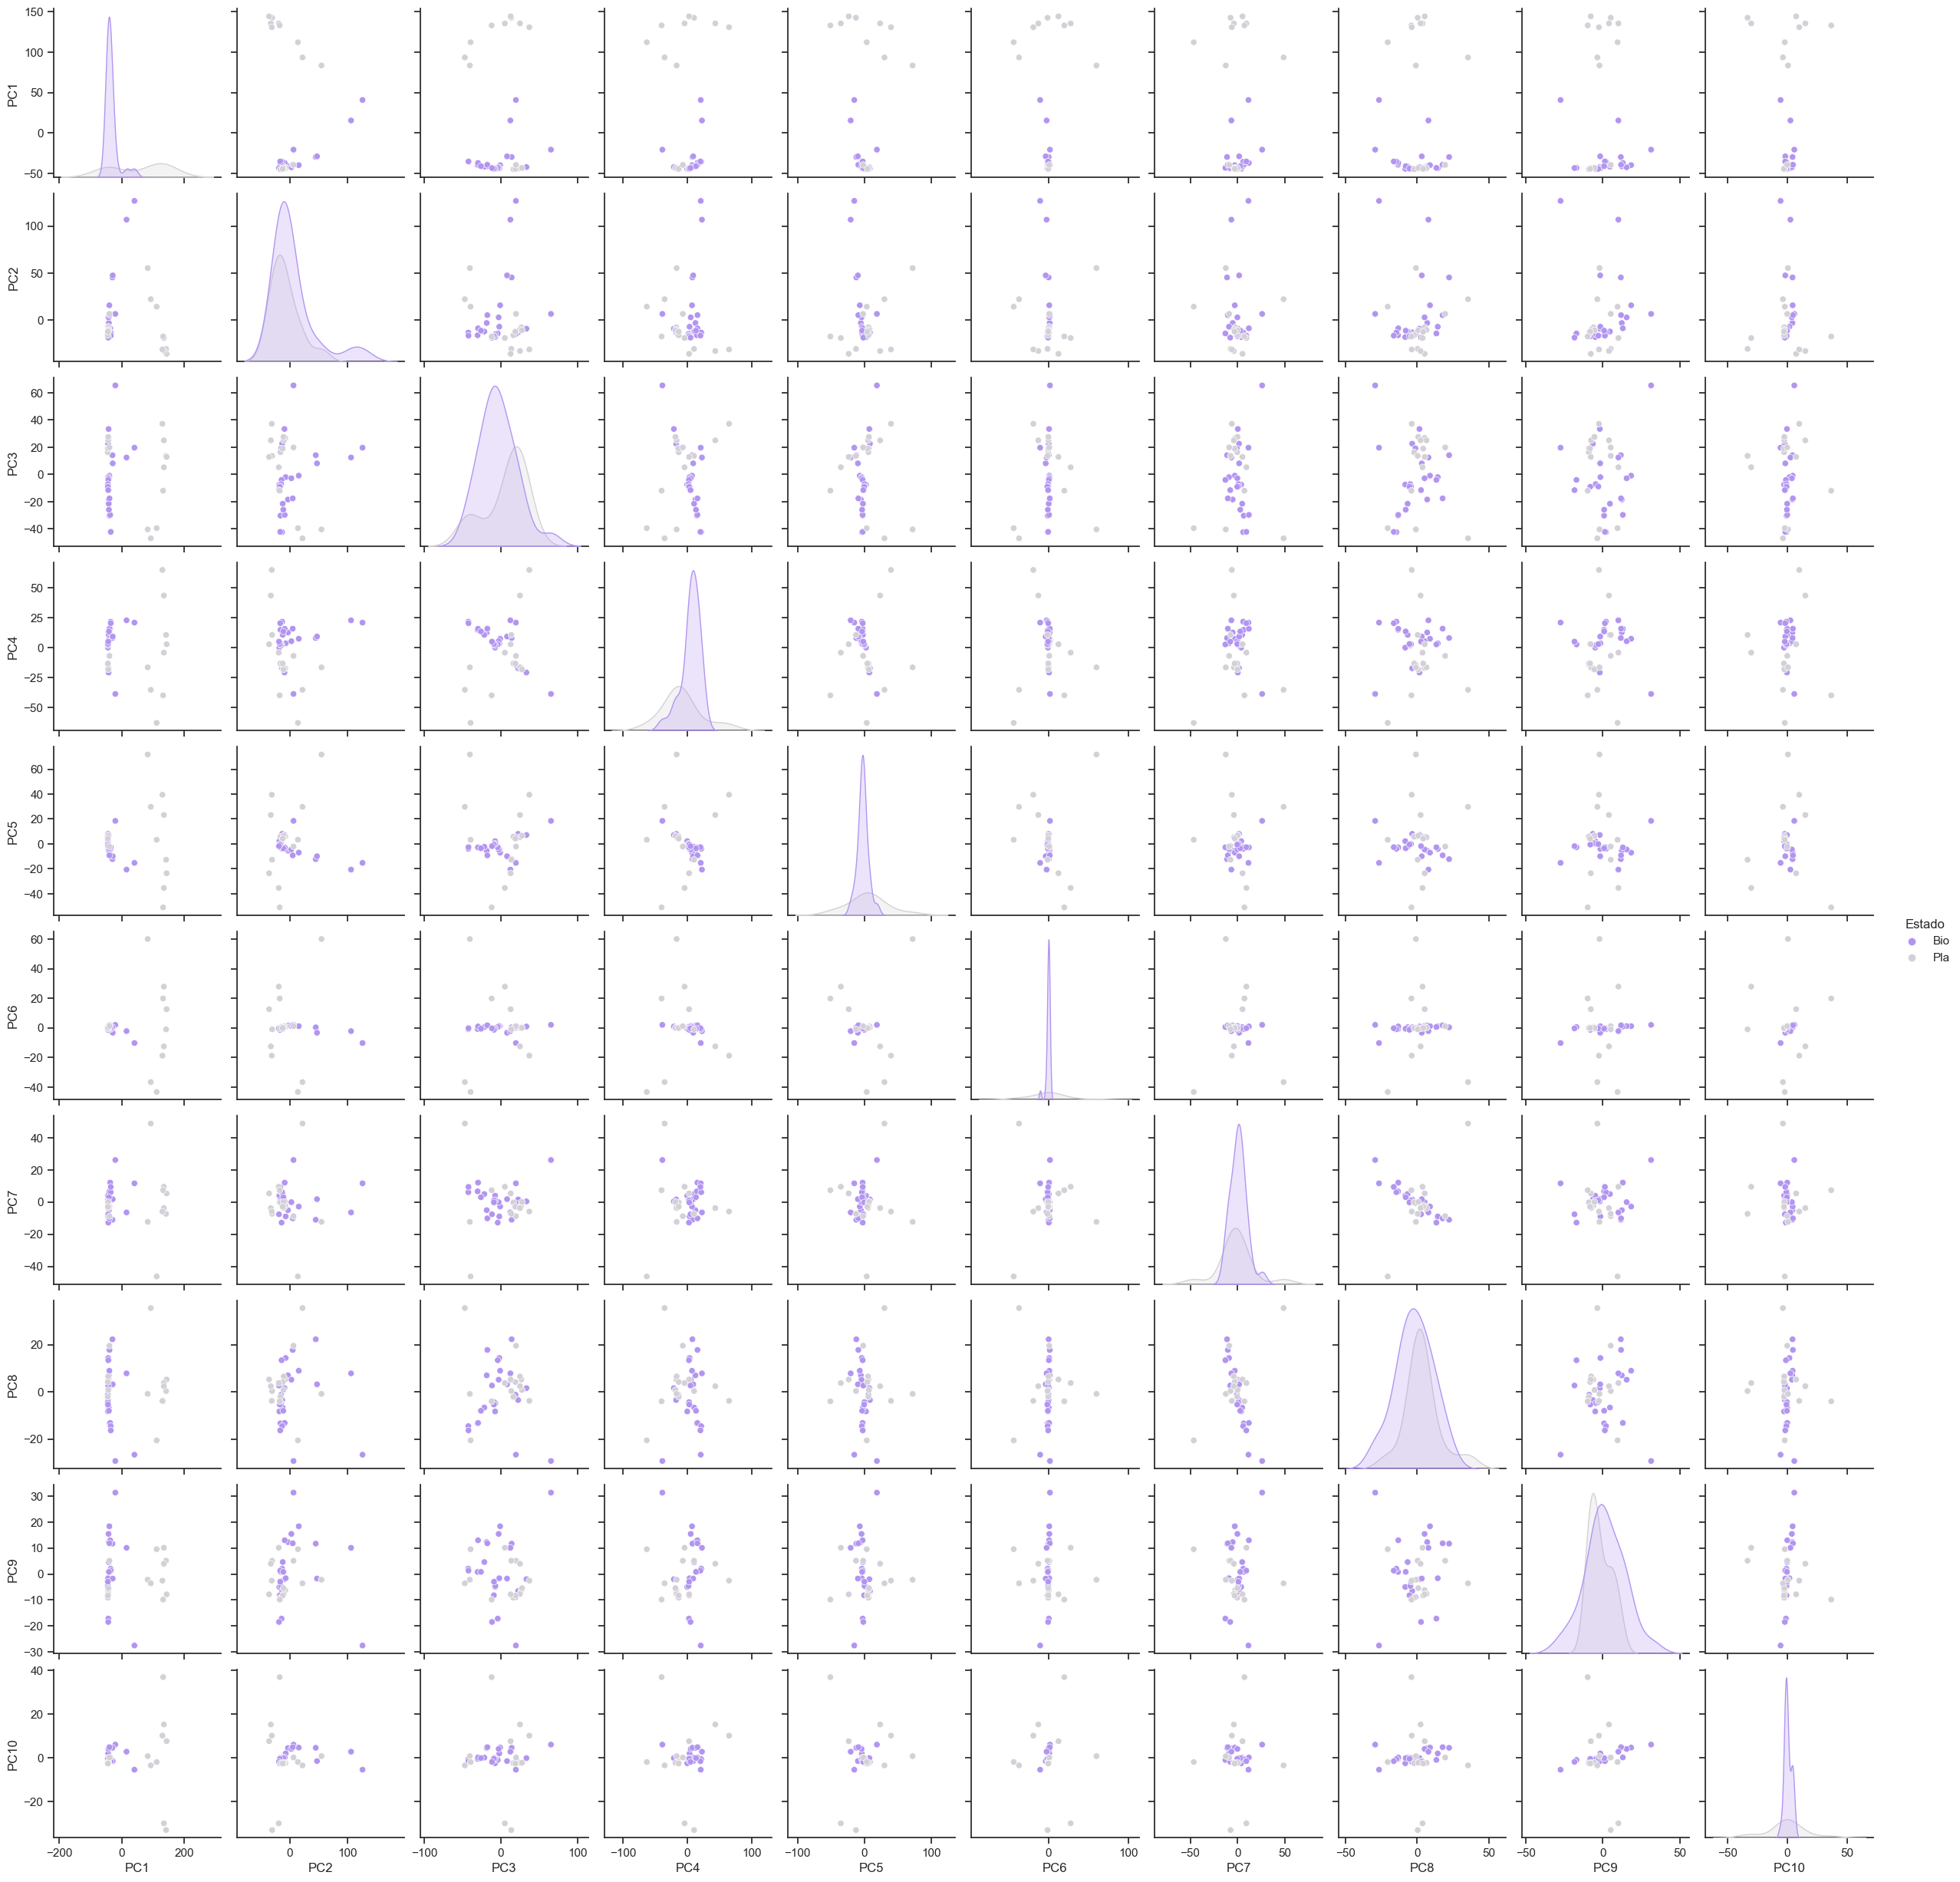

In [159]:
# Define una paleta de colores personalizada con colores más oscuros
custom_palette = ["#B295F0", "#D3D1D7"]  # Rojo oscuro y azul oscuro
Datos_pcaEt=pd.concat([Y1, scores_df], axis=1)
# Crea un diagrama de pares utilizando la paleta de colores personalizada
sns.set(style="ticks")
sns.pairplot(Datos_pcaEt , hue="Estado", palette=custom_palette)
# Muestra el diagrama de pares
plt.show()

In [7]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

encoder = OrdinalEncoder()
encoder.fit(Y1[['Estado']])
Y1_code = encoder.transform (Y1[['Estado']])
Y1_code = pd.DataFrame(Y1_code)

In [8]:
Y1_code.shape

(40, 1)

# Vector Máquina de Soporte

## "*rbf*"

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

modeloSVC1 = SVC(C = 60, kernel = 'rbf', random_state=123)
kf = KFold(n_splits=4, shuffle=True, random_state=123)

puntuaciones = cross_val_score(modeloSVC1, x_scaled.T, Y1_code.values.ravel(), cv=kf, scoring='f1')

# Imprime las puntuaciones obtenidas en cada fold
print("Puntuaciones de cada fold:", puntuaciones)

# Imprime la puntuación media y su desviación estándar
print("Puntuación media:", np.mean(puntuaciones))
print("Desviación estándar de las puntuaciones:", np.std(puntuaciones))


Puntuaciones de cada fold: [1.   1.   0.75 1.  ]
Puntuación media: 0.9375
Desviación estándar de las puntuaciones: 0.10825317547305488


In [10]:
# Ahora, puedes obtener el reporte de clasificación promediado sobre los folds
y_pred_cv = cross_val_predict(modeloSVC1, x_scaled.T, Y1_code.values.ravel(), cv=kf)
Matriz = confusion_matrix(Y1_code, y_pred_cv)
Reporte = classification_report(Y1_code, y_pred_cv)

print(Matriz)
print(Reporte)

[[25  0]
 [ 2 13]]
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96        25
         1.0       1.00      0.87      0.93        15

    accuracy                           0.95        40
   macro avg       0.96      0.93      0.95        40
weighted avg       0.95      0.95      0.95        40



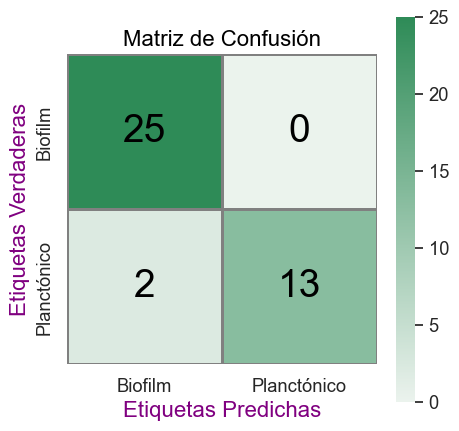

In [13]:
# Obtén la matriz de confusión
cm = confusion_matrix(Y1_code.values.ravel(), y_pred_cv)

# Colores personalizados
cmap = sns.light_palette("seagreen", as_cmap=True)

# Crea un mapa de calor (heatmap) con Seaborn
plt.figure(figsize=(5, 5))
sns.set(font_scale=1.2)  # Ajusta el tamaño de la fuente

# Ajusta el tamaño de fuente y otros atributos de texto dentro de la matriz
annot_kws = {"size": 28, "color": "black"}

sns.heatmap(Matriz, annot=True, fmt='d', cmap=cmap, cbar=True, square=True,
            xticklabels=['Biofilm', 'Planctónico'],
            yticklabels=['Biofilm', 'Planctónico'], linewidths=1, linecolor='gray',
            annot_kws=annot_kws)  # Aplica las configuraciones de annot_kws

plt.xlabel('Etiquetas Predichas', fontsize=16, color='purple')
plt.ylabel('Etiquetas Verdaderas', fontsize=16, color='purple')
plt.title('Matriz de Confusión', fontsize=16, color='black')
plt.savefig('Matriz SVC1', dpi=300)

plt.show()

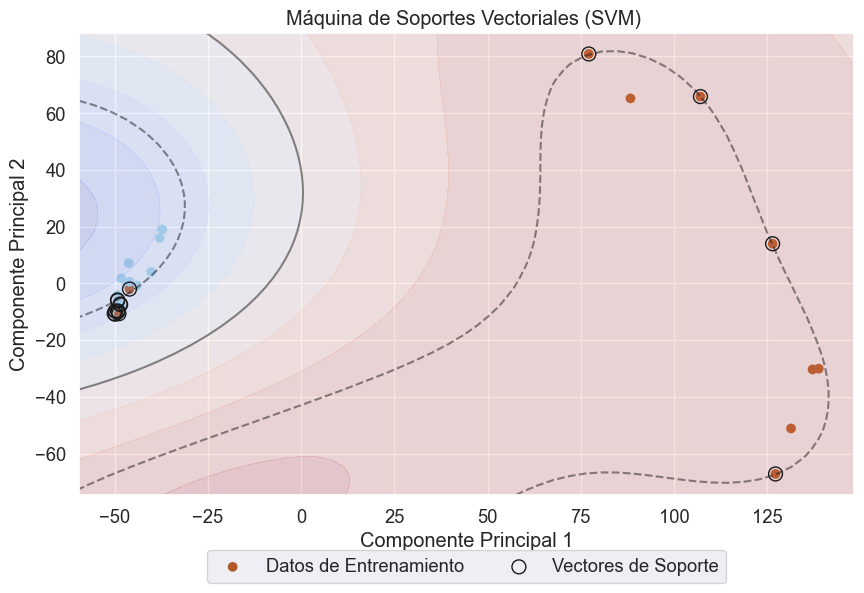

In [123]:
pca = PCA(n_components=2)
x_train_reduced = pca.fit_transform(x_train)

svc = SVC(C=60, kernel='rbf', random_state=9)
svc.fit(x_train_reduced, y_train)


# Gráfico de los datos de entrenamiento en 2D
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x_train_reduced[:, 0], x_train_reduced[:, 1], c=y_train, cmap=plt.cm.Paired, marker='o', label='Datos de Entrenamiento')

# Dibuja las regiones coloreadas entre las líneas de decisión
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50))
Z = svc.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
contour = plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.2)  # Colorea las regiones entre las líneas de decisión

# Dibuja el hiperplano de decisión en 2D
Z = svc.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

# Resalta todos los vectores de soporte y agrega la leyenda
support_vectors = svc.support_vectors_
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='k', label='Vectores de Soporte')

# Agrega leyendas para los elementos y coloca la leyenda en la esquina superior izquierda
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.title('Máquina de Soportes Vectoriales (SVM) ')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

## Gráficas de Comparación 1

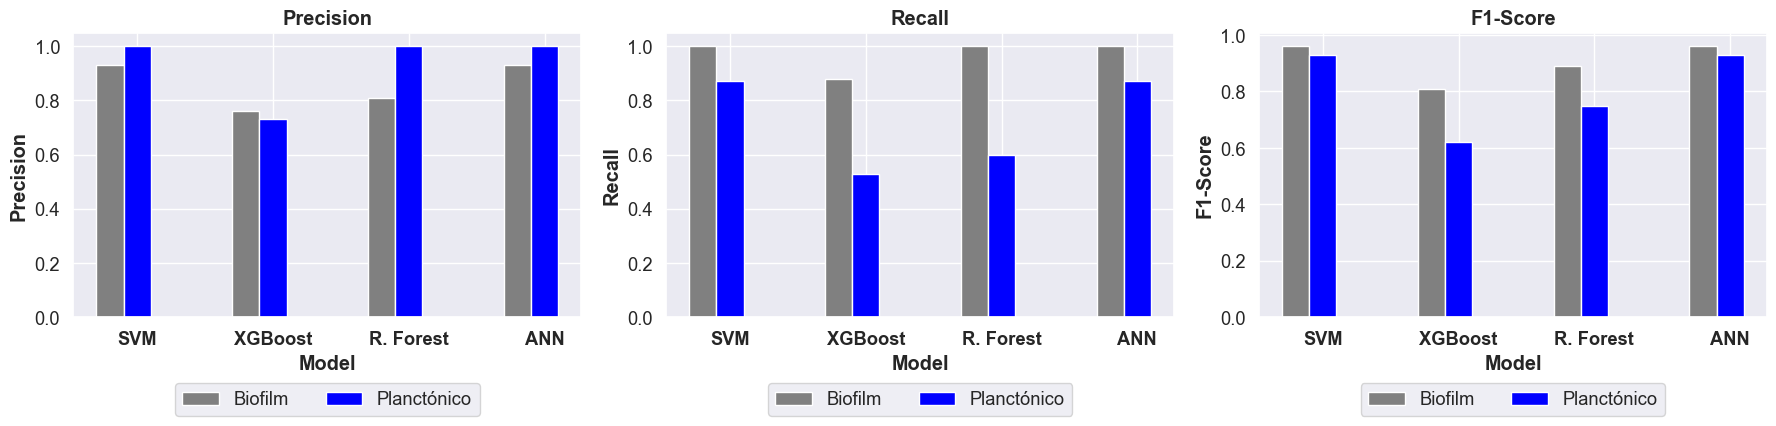

In [155]:
import matplotlib.pyplot as plt
import numpy as np

# Métricas y nombres de los modelos
model_names = ['SVM', 'XGBoost', 'R. Forest', 'ANN']
metrics = ['Precision', 'Recall', 'F1-Score']
class_labels = ['Biofilm', 'Planctónico']
colors = ['gray', 'blue']

# Valores de las métricas para cada modelo y clase
svm_values = {
    'Precision': [0.93, 1.0],
    'Recall': [1.0, 0.87],
    'F1-Score': [0.96, 0.93],
}

xgboost_values = {
    'Precision': [0.76, 0.73],
    'Recall': [0.88, 0.53],
    'F1-Score': [0.81, 0.62],
}

rf_values = {
    'Precision': [0.81, 1.0],
    'Recall': [1.0, 0.60],
    'F1-Score': [0.89, 0.75],
}

ann_values = {
    'Precision': [0.93, 1.0],
    'Recall': [1.0, 0.87],
    'F1-Score': [0.96, 0.93],
}

all_values = [svm_values, xgboost_values, rf_values, ann_values]

# Crear tres subplots para las métricas en gráficos separados
fig, axs = plt.subplots(1, 3, figsize=(18, 5))


for i in range(3):
    metric_name = metrics[i]
    width = 0.2
    x = np.arange(len(model_names))

    for k, class_label in enumerate(class_labels):
        class_values = [model_values[metric_name][k] for model_values in all_values]
        axs[i].bar(x + k * width, class_values, width, label=f'{class_label}', color=colors[k])

    axs[i].set_xlabel('Model',fontweight='bold')
    axs[i].set_ylabel(metric_name,fontweight='bold')
    axs[i].set_title(f'{metric_name}',fontweight='bold')
    axs[i].set_xticks(x + width)
    axs[i].set_xticklabels(model_names,fontweight='bold')
    axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

